In [2]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays

gr(size=(800,500),html_output_format=:png,
    seriescolor=:magma,background_color_legend=:white,
    background=RGB(((240,240,240) ./ 255.)...));

# Contact

## Single point with contact

In [3]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)

Environment(Contact[Contact(Spanning tree:
Vertex: world (root)
  Vertex: floor, Edge: floor_to_world
    Vertex: ball, Edge: floor_to_ball
No non-tree joints., ball, Point3D in "after_floor_to_ball": [0.0, 0.0, 0.0], Obstacle(floor, Point3D in "after_floor_to_world": [0.0, 0.0, 0.0], FreeVector3D in "after_floor_to_world": [0.0, 0.0, 1.0], [1.0 6.12323e-17 -1.0 -1.83697e-16; 0.0 1.0 1.22465e-16 -1.0; 0.0 0.0 0.0 0.0], 1.0, false))])

In [ ]:
sim_data = get_sim_data_indirect(mechanism,env,.005,relax_comp=false)
control! = (u,t,x) -> u[:] .= 0.
state0 = MechanismState(mechanism)
set_velocity!(state0, [0.,0.,0.,.3,0.,0.])
sim = Bilevel.simulate(sim_data,control!,state0,10)

In [ ]:
plot(sim[6],sim[7][5,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=4,marker=6)

In [ ]:
sim[1][end]

In [4]:
q1 = [1., 0., 0., 0., 0., 0., 0.]
qN = [1., 0., 0., 0., .004, 0., 0.]
N = 10
Δt = .005

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, length(q1), x -> vs(x, :q1) - q1)
    add_eq!(sim_data, :cqN, length(qN), x -> vs(x, Symbol("q", N)) - qN)
    add_eq!(sim_data, :cv1, 1, x -> vs(x, :v1)[6])
    add_eq!(sim_data, :cvN, 1, x -> vs(x, Symbol("v", N))[4])

    add_box_con!(sim_data, :u, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)
    add_box_con!(sim_data, :hbox, :h, 1. * [Δt], 1. * [Δt], 1:N-1)
end

add_prob_constraints! (generic function with 1 method)

In [8]:
sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
traj_indirect = Bilevel.trajopt(sim_data, quaternion_state=true, verbose=1)

Finished successfully: optimality conditions satisfied


(Array{Float64,1}[[1.0, -1.36315e-13, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, -1.36315e-13, 0.000111996, -3.73908e-18, 0.00128011, -8.05589e-13, 7.58708e-16], [1.0, -1.36315e-13, 0.000384679, -1.24278e-16, 0.00231483, -1.61118e-12, -5.0843e-20], [1.0, -1.36315e-13, 0.000576551, -8.45732e-17, 0.00310422, -2.41678e-12, 5.32473e-15], [1.0, 1.88537e-12, 0.00084813, 3.23266e-9, 0.00364821, -1.63588e-12, 0.0], [0.999999, 5.17756e-12, 0.00134661, 8.99917e-9, 0.00394671, 1.97632e-12, 6.46235e-27], [0.999999, -1.99561e-12, 0.00124707, -2.40921e-9, 0.004, -1.41667e-14, 2.32707e-11], [1.0, 0.0, 0.000826125, 0.0, 0.004, -1.80982e-17, 0.0], [1.0, 0.0, 0.000411403, 0.0, 0.004, 2.45e-13, 4.03184e-14], [1.0, 0.0, 0.0, 0.0, 0.004, 0.0, 0.0]], Array{Float64,1}[[0.0, 0.0, 0.0, 0.305082, -1.61118e-10, 0.0], [0.0, 0.0447985, 0.0, 0.256021, -1.61118e-10, 5.73468e-5], [0.0, 0.109073, 0.0, 0.206945, -1.61118e-10, 0.000159215], [0.0, 0.0767474, 0.0, 0.157875, -1.61118e-10, 0.000182046], [0.0, 0.108632, 1.29306e-6, 0.1

In [ ]:
sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
traj_semidirect = Bilevel.trajopt(sim_data, quaternion_state=true, verbose=1)

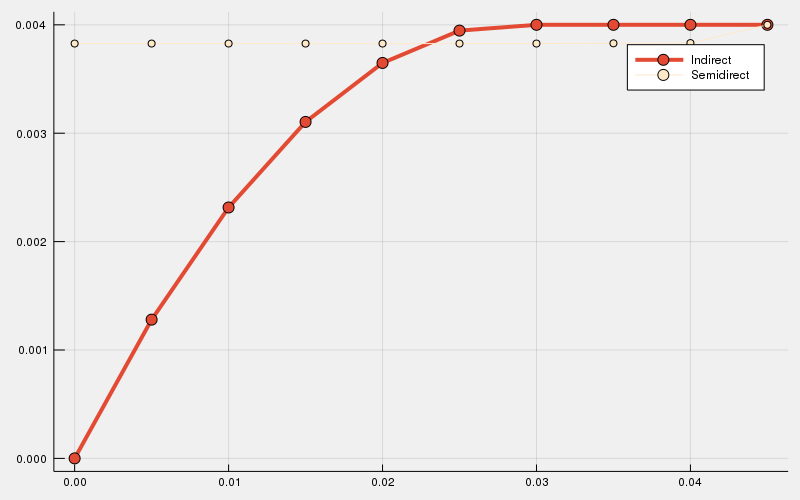

In [9]:
j = 5
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=4,marker=6)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=0,marker=4)

## Little dog

In [2]:
urdf = joinpath("..", "urdf", "little_dog", "little_dog.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [3]:
q_nom = [1., 0., 0., 0., 0., 0., .175, 0., 0., 0., 0., .036, 0., 0., 0., .00758, 0., .002445, 0.]  
q_min = [-1., -1., -1., -1., -.1, -.01, .05, -.6, -.6, -.6, -.6, -3.5, -3.5, -3.5, -3.5, -3.1, -3.1, -3.1, -3.1]
q_max = [1., 1., 1., 1., 5., .01, .2, .6, .6, .6, .6, 2.4, 2.4, 2.4, 2.4, 1., 1., 1., 1.]

N = 10
Δt = .05

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, num_positions(mechanism), x -> vs(x, :q1) - q_nom)
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))
end

function add_prob_obj!(sim_data)
    add_obj!(sim_data, :xf, x -> -sim_data.vs(x, Symbol("q", N))[5])
end

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [.5 * Δt], [2. * Δt], 1:N-1)
    
    # torques limits
    u_limit = .5
    add_box_con_snopt!(x_min, x_max, sim_data, :u, -u_limit * ones(num_velocities(mechanism)), u_limit * ones(num_velocities(mechanism)), 1:N-1)

    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        x0[sim_data.vs(Symbol("q", n))] .= q_nom
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

setup_prob! (generic function with 1 method)

In [5]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
open(mvis)

Could not open browser automatically: ErrorException("failed process: Process(`xdg-open http://127.0.0.1:8701`, ProcessExited(3)) [3]")
Please open the following URL in your browser:
http://127.0.0.1:8701


┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8701
└ @ MeshCat /home/blandry/.julia/packages/MeshCat/WlA0B/src/servers.jl:24
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'http://127.0.0.1:8701'
Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")
Stacktrace:
 [1] try_yieldto(::typeof(Base.ensure_rescheduled), ::Base.RefValue{Task}) at ./event.jl:196
 [2] wait() at ./event.jl:255
 [3] wait(::Condition) at ./event.jl:46
 [4] wait(::Task) at ./task.jl:188
 [5] create_socket(::Dict{Any,Any}) at /home/blandry/.julia/packages/WebIO/Rk8wc/src/providers/mux.jl:4

In [7]:
sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data)
traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=1e-3, major_feas=1e-3, minor_feas=1e-3);

Resource limit error: iteration limit reached


In [8]:
setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [9]:
sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data)
traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=1e-3, major_feas=1e-3, minor_feas=1e-3);


Error thrown in threaded loop on thread 0: InterruptException()

InterruptException: InterruptException:

Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")
Stacktrace:
 [1] try_yieldto(::typeof(Base.ensure_rescheduled), ::Base.RefValue{Task}) at ./event.jl:196
 [2] wait() at ./event.jl:255
 [3] wait(::Condition) at ./event.jl:46
 [4] wait(::Task) at ./task.jl:188
 [5] create_socket(::Dict{Any,Any}) at /home/blandry/.julia/packages/WebIO/Rk8wc/src/providers/mux.jl:44
 [6] (::getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)})(::Function, ::Dict{Any,Any}) at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:17
 [7] #1 at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:10 [inlined]
 [8] splitquery(::getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)},getfield(Mux, Symbol("##1#2")){typeof(Mux.wclose),getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol(

In [ ]:
setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [ ]:
traj_semidirect[1]

## Panda arm